# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import wasserstein

# directs standard out here instead of to the terminal
%load_ext wurlitzer

# EMD Usage

## Euclidean Ground Measure

In [28]:
# create an EMD object with the default parameters
emd = wasserstein.EMD()
print(emd)

EMD
  ArrayEvent<8-byte float>
    norm - false

  EuclideanArrayDistance
    R - 1
    beta - 1

  NetworkSimplex
    n_iter_max - 100000
    epsilon_large - 2.22045e-12
    epsilon_small - 2.22045e-16



In [29]:
# get some points in a euclidean space
M = 50
coords0, coords1 = np.random.rand(2, M, 2)
weights0, weights1 = np.random.rand(2, M)

# run EMD computation
emd_val = emd(weights0, coords0, weights1, coords1)
print('EMD value:', euclidean_emd)

# get flows
flows = emd.flows()
print('flows shape:', flows.shape)

# verify where extra particle got added
print('extra particle added to event', emd.extra())

EMD value: 5.539306551574456
flows shape: (50, 51)
extra particle added to event 1


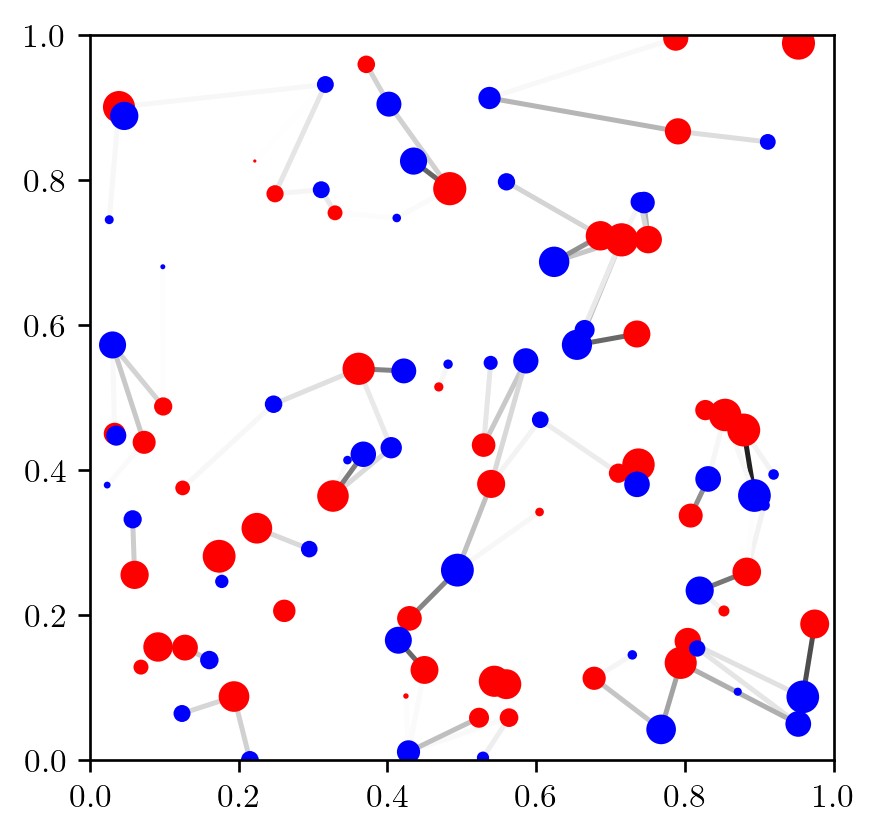

In [30]:
# plot the events
zf = 100
plt.scatter(coords0[:,0], coords0[:,1], s=zf*weights0, lw=0, color='red')
plt.scatter(coords1[:,0], coords1[:,1], s=zf*weights1, lw=0, color='blue')

# plot flows
cmap = plt.get_cmap('Greys')
fmax = flows.max()
for i in range(len(weights0)):
    for j in range(len(weights1)):
        f = flows[i,j]
        if f > 0.:
            plt.plot([coords0[i,0], coords1[j,0]], [coords0[i,1], coords1[j,1]],
                     lw=1.5, color=cmap(f/fmax), zorder=0)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

## Custom Ground Measure

In [31]:
from scipy.spatial.distance import cdist

In [32]:
# use manhattan distances
city_dists = cdist(coords0, coords1, 'cityblock')

# use norm=True here to avoid having to equalize the weights ourselves
emd = wasserstein.EMD(norm=True)

# solve EMD problem
city_emd = emd(weights0, weights1, city_dists)
city_flows = emd.flows()

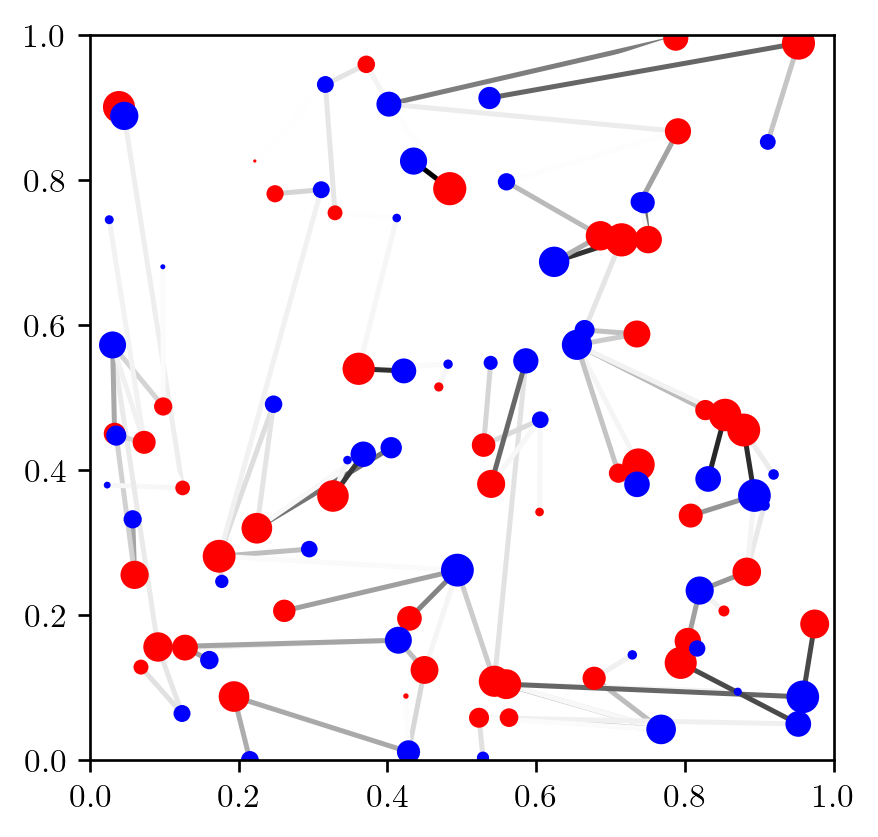

In [33]:
# plot the events
zf = 100
plt.scatter(coords0[:,0], coords0[:,1], s=zf*weights0, lw=0, color='red')
plt.scatter(coords1[:,0], coords1[:,1], s=zf*weights1, lw=0, color='blue')

# plot flows (notice that they tend to align much more with the axes due to the metric choice)
cmap = plt.get_cmap('Greys')
fmax = city_flows.max()
for i in range(len(weights0)):
    for j in range(len(weights1)):
        f = city_flows[i,j]
        if f > 0.:
            plt.plot([coords0[i,0], coords1[j,0]], [coords0[i,1], coords1[j,1]],
                     lw=1.5, color=cmap(f/fmax), zorder=0)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

## Check Optimality of Transportation Plans

In [40]:
# the cost of the euclidean flow plan with the cityblock distance
# should be more than the cityblock plan and vice versa
euclidean_dists = cdist(coords0, coords1)
euclidean_emd = emd(weights0, weights1, euclidean_dists)
euclidean_flows = emd.flows()

# swap flow plans
euclidean_flows_city_dists = np.sum(euclidean_flows*city_dists)
city_flows_euclidean_dists = np.sum(city_flows*euclidean_dists)

# the first value should be smaller
print('Euclidean EMD flows, Euclidean dists', euclidean_emd)
print('Cityblock EMD flows, Euclidean dists', city_flows_euclidean_dists)

# the second value should be smaller
print('Euclidean EMD flows, cityblock dists', euclidean_flows_city_dists)
print('Cityblock EMD flows, cityblock dists', city_emd)

Euclidean EMD flows, Euclidean dists 0.1379426137030905
Cityblock EMD flows, Euclidean dists 0.1414012180104024
Euclidean EMD flows, cityblock dists 0.17218629582683764
Cityblock EMD flows, cityblock dists 0.16965437271172573


# PairwiseEMD Usage

In [31]:
# create PairwiseEMD object
emds = wasserstein.PairwiseEMD(norm=True)
print(emds)

PairwiseEMD
  ArrayEvent<8-byte float>
    norm - true

  EuclideanArrayDistance
    R - 1
    beta - 1

  NetworkSimplex
    n_iter_max - 100000
    epsilon_large - 2.22045e-12
    epsilon_small - 2.22045e-16

  num_threads - 8
  print_every - auto, 10 total chunks
  store_sym_emds_flattened - true
  throw_on_error - false

  Pairwise EMD distance matrix stored internally



In [32]:
# get a collection of events
Mmin, Mmax = 4, 5
N = 800
ground_dim = 3
events = [np.random.rand(np.random.randint(Mmin, Mmax), 1+ground_dim) for i in range(N)]

# compute pairwise emds
emds(events)

Finished preprocessing 800 events in 0.0055s
   31960 / 319600  EMDs computed  -  10.00% completed - 0.015s
   63920 / 319600  EMDs computed  -  20.00% completed - 0.028s
   95880 / 319600  EMDs computed  -  30.00% completed - 0.036s
  127840 / 319600  EMDs computed  -  40.00% completed - 0.045s
  159800 / 319600  EMDs computed  -  50.00% completed - 0.054s
  191760 / 319600  EMDs computed  -  60.00% completed - 0.062s
  223720 / 319600  EMDs computed  -  70.00% completed - 0.070s
  255680 / 319600  EMDs computed  -  80.00% completed - 0.079s
  287640 / 319600  EMDs computed  -  90.00% completed - 0.087s
  319600 / 319600  EMDs computed  - 100.00% completed - 0.096s


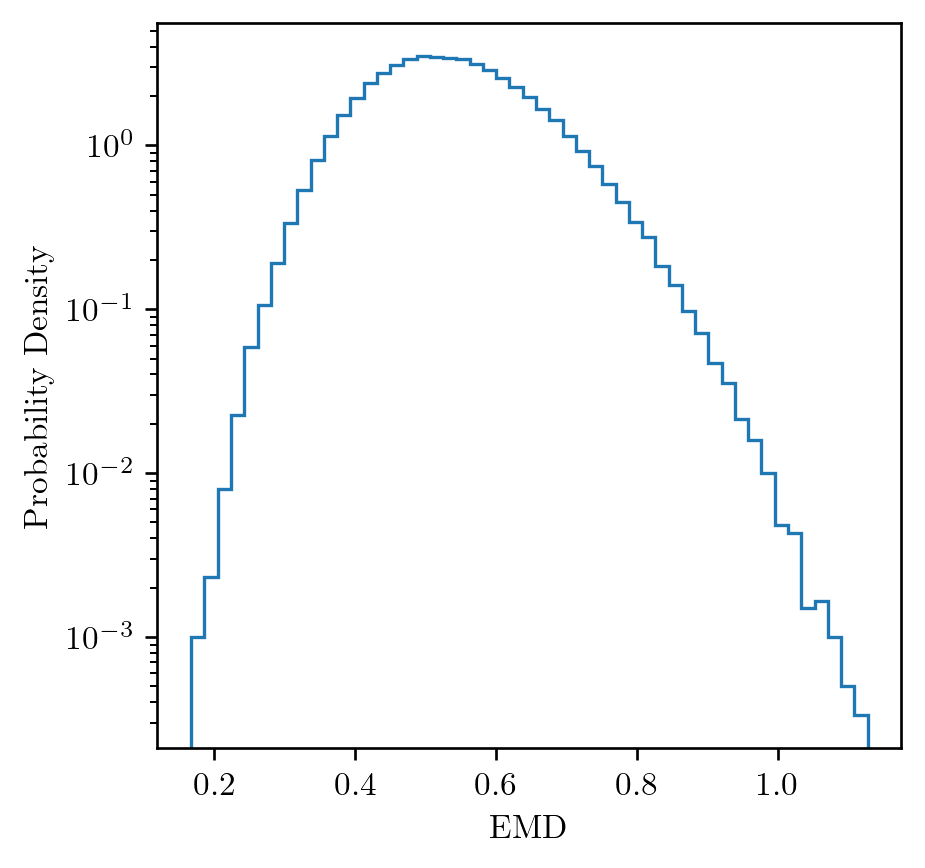

In [33]:
# get emds
emds_arr = emds.emds()

# display histogram of unique emd values
unique_emds = emds_arr[np.triu(emds_arr) > 0]
assert len(unique_emds) == N*(N-1)//2

plt.hist(unique_emds, bins=51, histtype='step', density=True)

plt.yscale('log')

plt.xlabel('EMD')
plt.ylabel('Probability Density')

plt.show()

# CorrelationDimension Usage

The `CorrelationDimension` class is an example of an external EMD handler, that is, something that we can provide to a `PairwiseEMD` object that will accept the EMD values on the fly. In this case, the EMD values are histogrammed according to settings specified in the `CorrelationDimension` object, which can then be used to calculate the correlation dimension, which is a particular transformation of the histogram of EMD values.

In [34]:
# create correlation dimension object
EMDlow, EMDhigh = 0.18, 1.15
nbins = 61
corrdim = wasserstein.CorrelationDimension(EMDlow, EMDhigh, nbins)
print(corrdim)

  ExternalEMDHandler - CorrelationDimension
    range - [0.18, 1.15)
    bins - 61
    axis_transform - log



In [35]:
# set corrdim as external handler to emds, notice that the EMDs are no longer stored internally
emds.set_external_emd_handler(corrdim)
print(emds)

PairwiseEMD
  ArrayEvent<8-byte float>
    norm - true

  EuclideanArrayDistance
    R - 1
    beta - 1

  NetworkSimplex
    n_iter_max - 100000
    epsilon_large - 2.22045e-12
    epsilon_small - 2.22045e-16

  num_threads - 8
  print_every - auto, 10 total chunks
  store_sym_emds_flattened - true
  throw_on_error - false

  ExternalEMDHandler - CorrelationDimension
    range - [0.18, 1.15)
    bins - 61
    axis_transform - log



In [36]:
# run computation
emds(events)

Finished preprocessing 800 events in 0.0079s
   31960 / 319600  EMDs computed  -  10.00% completed - 0.019s
   63920 / 319600  EMDs computed  -  20.00% completed - 0.029s
   95880 / 319600  EMDs computed  -  30.00% completed - 0.040s
  127840 / 319600  EMDs computed  -  40.00% completed - 0.051s
  159800 / 319600  EMDs computed  -  50.00% completed - 0.062s
  191760 / 319600  EMDs computed  -  60.00% completed - 0.073s
  223720 / 319600  EMDs computed  -  70.00% completed - 0.084s
  255680 / 319600  EMDs computed  -  80.00% completed - 0.095s
  287640 / 319600  EMDs computed  -  90.00% completed - 0.106s
  319600 / 319600  EMDs computed  - 100.00% completed - 0.116s


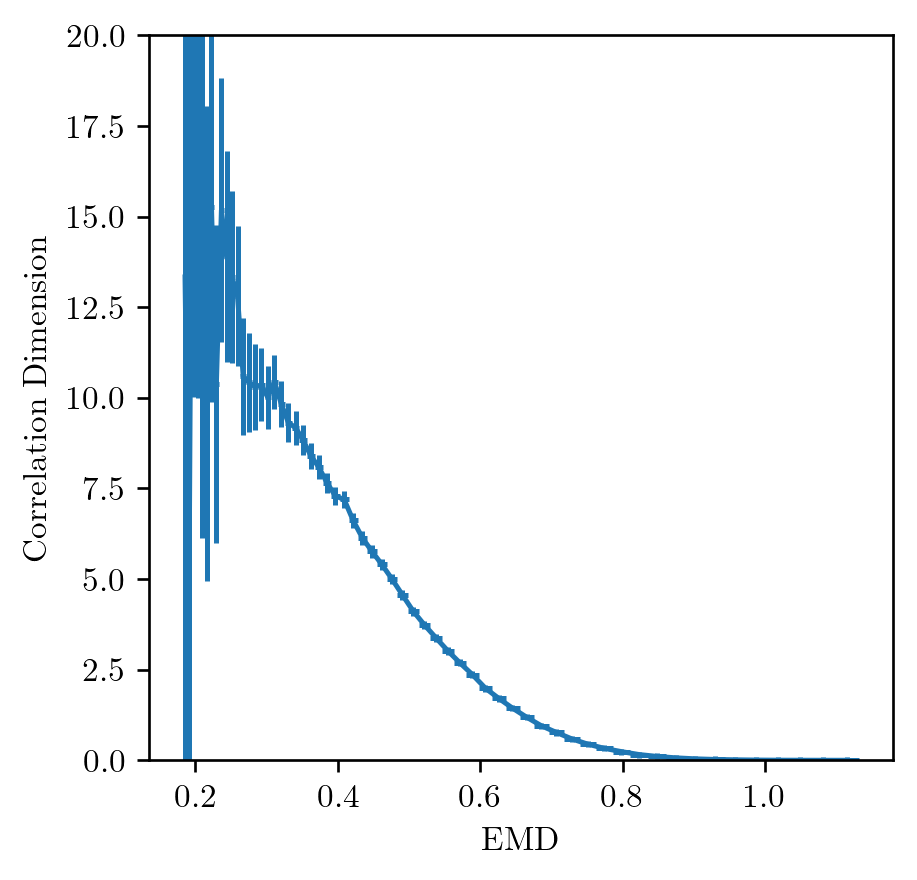

In [40]:
# view correlation dimension
cd_vals, cd_errs = corrdim.corrdims()
midbins, cd_bins = corrdim.bin_centers(), corrdim.corrdim_bins()
plt.errorbar(cd_bins, cd_vals, yerr=cd_errs, xerr=(cd_bins - midbins[:-1], midbins[1:] - cd_bins))
plt.ylim(0, 20)

plt.xlabel('EMD')
plt.ylabel('Correlation Dimension')

plt.show()